In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn import tree
from matplotlib.colors import ListedColormap

from lightgbm import LGBMClassifier
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/sample_submission.csv
/kaggle/input/mlbio1/test.csv


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

In [11]:
#vieving what kind of data I have

In [12]:
sample

,id,stroke
0,37061,0.5
1,42333,0.5
2,58964,0.5
3,34063,0.5
4,43682,0.5
...,...,...
13395,56196,0.5
13396,5450,0.5
13397,28375,0.5
13398,27973,0.5


In [13]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


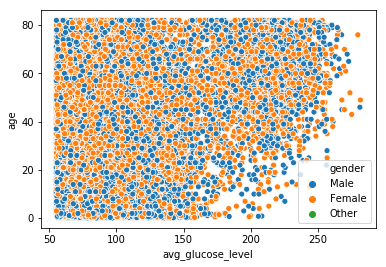

In [43]:
sns.scatterplot(x=train['bmi'], y=train['age'], hue=train['gender'])

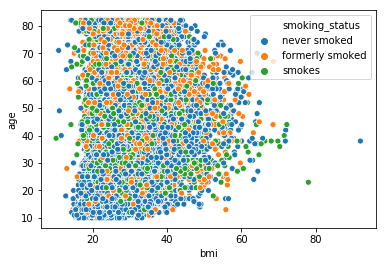

In [38]:
sns.scatterplot(x=train['bmi'], y=train['age'], hue=train['smoking_status'])

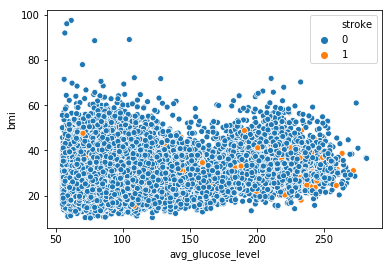

In [41]:
sns.scatterplot(x=train['avg_glucose_level'], y=train['bmi'],hue=train['stroke'])

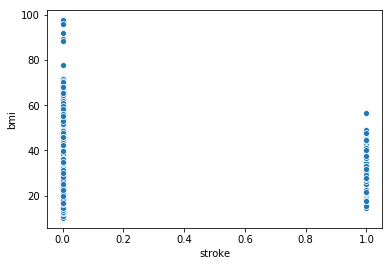

In [32]:
sns.scatterplot(x=train['stroke'], y=train['bmi'])

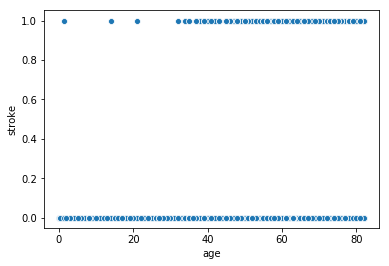

In [29]:
sns.scatterplot(x=train['age'], y=train['stroke'])

In [ ]:
#in this previous two plots can see the dependence

In [16]:
train['stroke'].fillna('nan').value_counts()

0    29471
1      530
Name: stroke, dtype: int64

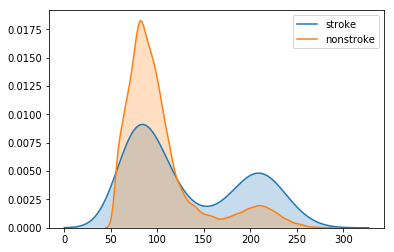

In [21]:
sns.kdeplot(data=train.loc[train['stroke']==1,'avg_glucose_level'], label="stroke", shade=True)
sns.kdeplot(data=train.loc[train['stroke']==0,'avg_glucose_level'], label="nonstroke", shade=True)

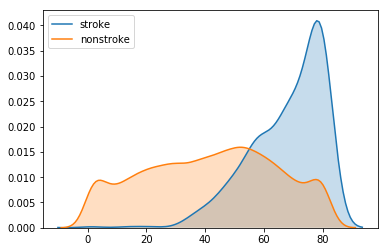

In [22]:
sns.kdeplot(data=train.loc[train['stroke']==1,'age'], label="stroke", shade=True)
sns.kdeplot(data=train.loc[train['stroke']==0,'age'], label="nonstroke", shade=True)

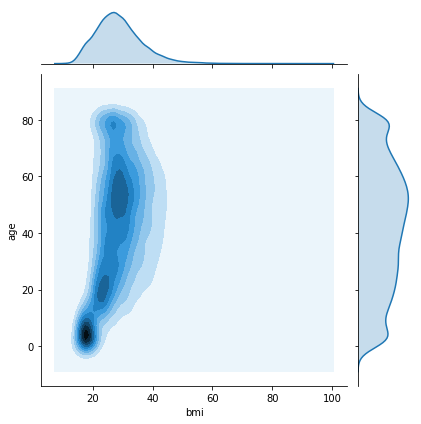

In [14]:
sns.jointplot(x=train['bmi'], y=train['age'], kind="kde")

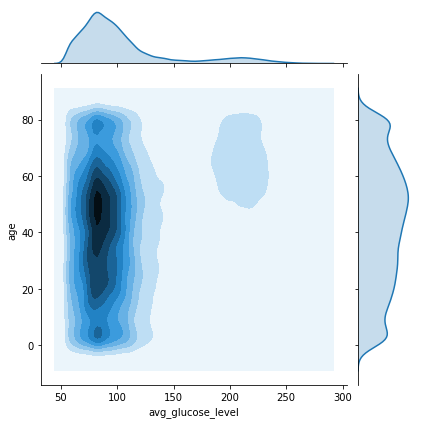

In [15]:
sns.jointplot(x=train['avg_glucose_level'], y=train['age'], kind="kde")

In [23]:
train['smoking_status'].fillna('nan').value_counts()

never smoked       11079
nan                 9176
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

In [ ]:
train['Residence_type'].fillna('nan').value_counts()

In [ ]:
#updatig column residence type, via dictionary

In [ ]:
Residence_type_dict = {'Rural': 1, 'Urban':0 }

In [ ]:
train['Residence_type'] =train['Residence_type'].replace(Residence_type_dict)
test['Residence_type'] = test['Residence_type'].replace(Residence_type_dict)

In [ ]:
#updatig column bmi, use mean values

In [ ]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

In [ ]:
test.head()

In [ ]:
#updatig column work type, via target encoding and dictionary

In [ ]:
train['work_type'].fillna('nan').value_counts()

In [ ]:
(train.groupby(['work_type'])['stroke'].agg(['mean'])).to_dict()

In [ ]:
work_type_target_enc_dict = (train.groupby(['work_type'])['stroke'].agg(['mean'])).to_dict()['mean']

In [ ]:
work_type_target_enc_dict

In [ ]:
train['work_type_target_enc'] = train['work_type'].replace(work_type_target_enc_dict)
test['work_type_target_enc'] = test['work_type'].replace(work_type_target_enc_dict)

In [ ]:
for i in train['work_type'].unique():
    print(i)
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

In [ ]:
work_type_dict = {'Govt_job' : 2, 'Private' : 2,'Self-employed': 1,'Never_worked': 1, 'children':0 }

In [ ]:
train['work_type'] =train['work_type'].replace(work_type_dict)
test['work_type'] = test['work_type'].replace(work_type_dict)

In [ ]:
#updatig column gender, via target encoding and dictionary

In [ ]:
gender_dict = {'Male': 0, 'Female':2, 'Other': 1 }

In [ ]:
train['gender'].fillna('nan').value_counts()

In [ ]:
(train.groupby(['gender'])['stroke'].agg(['mean']))

In [ ]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']

train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)

In [ ]:
train['gender'] =train['gender'].replace(gender_dict)
test['gender'] = test['gender'].replace(gender_dict)

In [ ]:
#updatig column ever married, via  dictionary 

In [ ]:
train['ever_married'].value_counts()

In [ ]:
ever_married_dict = {'Yes': 1, 'No':0 }

In [ ]:
train['ever_married'] =train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

In [ ]:
#updatig column smoking_status, via target encoding, mean and dictionary 

In [ ]:
train['smoking_status'].unique()

In [ ]:
train['smoking_status'].value_counts()

In [ ]:
smoking_status_dict = {'smokes': 2,'formerly smoked': 1, 'never smoked':0 }

In [ ]:
train['smoking_status'] = train['smoking_status'].replace(smoking_status_dict)
test['smoking_status'] = test['smoking_status'].replace(smoking_status_dict)

In [ ]:
mean_smoking_status = train['smoking_status'].mean()

In [ ]:
#train['smoking_status'] = train['smoking_status'].fillna('nan')
#test['smoking_status'] = test['smoking_status'].fillna('nan')

In [ ]:
#(train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()

In [ ]:
#smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']

In [ ]:
#smoking_status_target_enc_dict

In [ ]:
#train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
#test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)

In [ ]:
test.head()

In [ ]:
#finally use dict and mean values as this gives higher score

In [ ]:
train.loc[train['age']<15,'smoking_status'] = 0
test.loc[test['age']<15,'smoking_status'] = 0

train['smoking_status'] = train['smoking_status'].fillna(mean_smoking_status)
test['smoking_status'] = test['smoking_status'].fillna(mean_smoking_status)

In [ ]:
#create some list of features

In [ ]:
features = ['age', 'ever_married','avg_glucose_level','heart_disease','hypertension', 'bmi', 'smoking_status', 'Residence_type']

In [ ]:
test.head()

In [ ]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

In [ ]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgb =   LGBMClassifier(n_estimators=100, max_depth=5)

In [ ]:
#defining some useful stuff

In [ ]:
def my_cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return scores


In [ ]:
# here use clf 

In [ ]:
scores = my_cross_validation_for_roc_auc(clf, train[features] , train['stroke'])


In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
#here use lgb

In [ ]:
scores = my_cross_validation_for_roc_auc(lgb, train[features] , train['stroke'])

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
#put all features obtained previosly in a list

In [ ]:
all_features = [ 'age', 'hypertension', 'heart_disease', 'ever_married',
        'Residence_type', 'avg_glucose_level', 'bmi','work_type','work_type_target_enc','work_type_is_children',
       'work_type_is_Private', 'work_type_is_Never_worked','work_type_is_Self-employed',
        'work_type_is_Govt_job','smoking_status', 'gender_target_enc','gender']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30)

In [ ]:
#для clf выбираем гипермараметры

In [ ]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(clf, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

In [ ]:
features_2 = ['age','work_type', 'gender','ever_married','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension','smoking_status']

In [ ]:
scores = my_cross_validation_for_roc_auc(clf, train[features_2] , train['stroke'])

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

clf.fit(train[features_2], train['stroke'])

In [ ]:
clf.predict_proba(test[features_2])

In [ ]:
prediction = clf.predict_proba(test[features_2])[:,1]

In [ ]:
sample['stroke'] = prediction

In [ ]:
sample.to_csv('submit_ex.csv', index = None )

In [ ]:
#для lgb выбираем гипер параметры

In [ ]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(lgb, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

In [ ]:
features_3 = ['age', 'ever_married','work_type','gender','gender_target_enc','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension', 'bmi', 'smoking_status']

In [ ]:
scores = my_cross_validation_for_roc_auc(lgb, train[features_3] , train['stroke'])

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
lgb.fit(train[features_3], train['stroke'])

In [ ]:
lgb.predict_proba(test[features_3])

In [ ]:
prediction = lgb.predict_proba(test[features_3])[:,1]

In [ ]:
sample['stroke'] = prediction

In [ ]:
#sample.to_csv('submit_ex.csv', index = None )

In [ ]:
#для knn выбираем гиперпараметры

In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)

In [ ]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(knn, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

In [ ]:
features_4 = ['age', 'ever_married','work_type','gender','gender_target_enc','Residence_type','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension', 'bmi','smoking_status']

In [ ]:
scores = my_cross_validation_for_roc_auc(knn, train[features_4] , train['stroke'])

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
knn.fit(train[features_4], train['stroke'])

In [ ]:
knn.predict_proba(test[features_4])

In [ ]:
prediction = knn.predict_proba(test[features_4])[:,1]

In [ ]:
sample['stroke'] = prediction

In [ ]:
#sample.to_csv('submit_ex.csv', index = None )